In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
from BoreholeFlow import BhFlow
from BoreholeFlow import invertBHconc
from BoreholeFlow import PlotFigures
import quadprog as qp
np.set_printoptions(precision=15)

In [2]:
# Created by Joshua Thompson 
# Last updated 09/02/2022

path2randvector =  r"..\Input_Data\randvector.txt"
randvector = np.asarray(pd.read_csv(path2randvector, header = None))

alphmax = 1 #Upper bound for alpha
alph = 1e-3
concerr = 5
nskip = 2

R0 = 1000.0000
Rw = 20.32 / 2
dhtotal = 2.5

Qsampling = 100 / 60
zwellbot = -5000

# Hydraulic conductivity (cm/s)
K = [1e-5, 3e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 6e-5, 1e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 6e-5, 3e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4]
K = np.array([i * 100 for i in K]).reshape(25, 1) # apply list comprehension for multiplying 100 by each element in list.

# True concentration in the aquifer (mg/cm^3)
C0 = np.array([500, 400, 300, 250, 40, 25, 30, 50, 150, 400, 500, 300, 50, 40, 30, 25, 50, 150, 300, 500, 300, 150, 40, 30, 20])

# -----------------------------------------------------
# Instantiate the class
# -----------------------------------------------------
p = BhFlow(K, R0, Rw)

# Define number of layers based on the number of Ks
nlayers = p.NumberOfLayers()

# Create thickness of each wellbore interval
b = 200 * p.NlayersOnesArray(nlayers)

zobs = np.arange(b[0] / 2, np.sum(b) - b[-1]/2 + 1, nskip * b[0]) + zwellbot
nobs = len(zobs)

X = p.NlayersOnesArray(nlayers)

# Define layer head drops.
Keff = np.sum(b) / np.sum(b / K) # effective hydraulic conductivity

dh = Keff/K * b/np.sum(b) * dhtotal # head drops

h0 = p.NlayersZerosArray(nlayers) # Far field heads (in Aquifer)
h0[0] = dh[0] / 2 + 10000
for i in np.arange(1,nlayers):
    h0[i] = h0[i-1] + dh[i-1]/2 + dh[i]/2

ztop, zmid, zbot = p.Discretize(zwellbot, nlayers, b) # Discretize the well

# -----------------------------------------------------
# -----------------------------------------------------
# L-F dataset with no other pumping (Qpump=0)
# -----------------------------------------------------
# -----------------------------------------------------
zpump = -100 *np.ones((1,1))
Qsampling = 100 / 60
Qpump = np.zeros((1,1))

# Create empty list to store data
ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll = p.MakeDataLists()

for i in range(len(zobs)):
    # Run flow model
    Qb, Qr, h, zmid, zbot, ztop= p.BoreholeFlowModel(nlayers, b, h0, zwellbot, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    # Run transport model
    c, cobs, G = p.BoreholeTransportModel(nlayers, b, Qb, Qr, C0, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    # Append data to empty lists
    ctrueLF1, cobsLF1, gLF1, zobsLF1, zpumpLF1, QpumpLF1, QobsLF1, QbLF1, QrLF1, hLF1 = p.AppendData(c, cobs, G, zobs[i], zpump, Qpump, Qsampling, Qb, Qr, h, ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll)
# Convert list to array and transpose data
ctrueLF1, cobsLF1, gLF1, zobsLF1, zpumpLF1, QpumpLF1, QobsLF1, QbLF1, QrLF1, hLF1 = p.Convert2Arrays(zobs, nlayers, ctrueLF1, cobsLF1, gLF1, zobsLF1, zpumpLF1, QpumpLF1, QobsLF1, QbLF1, QrLF1, hLF1)

cobsLF1 = cobsLF1 + randvector * concerr
s = invertBHconc(nlayers, gLF1, X, cobsLF1, concerr, alphmax, alph)
c0estLF1, rmsLF1, RLF1 = s.InvertData()

# -----------------------------------------------------
# -----------------------------------------------------
# L-F dataset with pumping (Qpump=8 L/min)
# -----------------------------------------------------
# -----------------------------------------------------
Qpump = 8000 / 60
Qsampling = 100/ 60
path2randvector2 = r"..\Input_Data\randvector2.txt"

randvector2 = np.asarray(pd.read_csv(path2randvector2, header = None))

# Create empty list to store data
ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll = p.MakeDataLists()

for i in range(len(zobs)):
    # Run flow model
    Qb, Qr, h, zmid, zbot, ztop = p.BoreholeFlowModel(nlayers, b, h0, zwellbot, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)

#     Run transport model
    c, cobs, G = p.BoreholeTransportModel(nlayers, b, Qb, Qr, C0, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
#     Append data to empty lists
    ctrueLF2, cobsLF2, gLF2, zobsLF2, zpumpLF2, QpumpLF2, QobsLF2, QbLF2, QrLF2, hLF2 = p.AppendData(c, cobs, G, zobs[i], zpump, Qpump, Qsampling, Qb, Qr, h, ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll)

# Convert list to array and transpose data
ctrueLF2, cobsLF2, gLF2, zobsLF2, zpumpLF2, QpumpLF2, QobsLF2, QbLF2, QrLF2, hLF2 = p.Convert2Arrays(zobs, nlayers, ctrueLF2, cobsLF2, gLF2, zobsLF2, zpumpLF2, QpumpLF2, QobsLF2, QbLF2, QrLF2, hLF2)

cobsLF2 = cobsLF2 + randvector2 * concerr

s = invertBHconc(nlayers, gLF2, X, cobsLF2, concerr, alphmax, alph)
c0estLF2, rmsLF2, RLF2 = s.InvertData()

# -----------------------------------------------------
# -----------------------------------------------------
# Combined Dataset
# -----------------------------------------------------
# -----------------------------------------------------
ctrueCombine, cobsCombine, gCombine, zobsCombine, zpumpCombine, QpumpCombine, QobsCombine, QbCombine, QrCombine, hCombine = p.CombineFandTOutput(ctrueLF1, ctrueLF2, cobsLF1, cobsLF2, gLF1, gLF2, zobsLF1, zobsLF2, zpumpLF1, zpumpLF2, QpumpLF1, QpumpLF2, QobsLF1, QobsLF2, QbLF1, QbLF2, QrLF1, QrLF2, hLF1, hLF2)
s = invertBHconc(nlayers, gCombine, X, cobsCombine, concerr, alphmax, alph)
c0estCombine, rmsCombine, RCombine = s.InvertData()

# -----------------------------------------------------
# -----------------------------------------------------
# # Consider non-uniform zonation (4 zones)
# -----------------------------------------------------
# -----------------------------------------------------
path2XZone = r"..\Input_Data\XZone.txt"
XZone = np.asarray(pd.read_csv(path2XZone, header = None, sep = '\s+'))
s = invertBHconc(nlayers, gCombine, XZone, cobsCombine, concerr, alphmax, alph)
c0estComX, rmsComX, RComX = s.InvertData()

negative concentrationm estimates produced; switching to quadratic programming -1.464335380142245


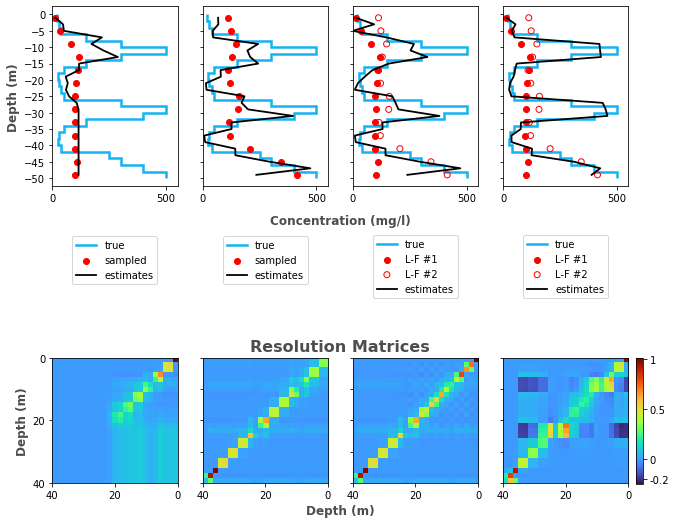

In [3]:
plot = PlotFigures()
plot.PlotFigure5(C0, cobsLF1, zobsLF1, c0estLF1, cobsLF2, zobsLF2, c0estLF2, c0estCombine[0], c0estComX, zmid, RLF1, RLF2, RCombine, RComX)

In [4]:
# -----------------------------------------------------
# EXPORTING FOR DATA VALIDATION
# -----------------------------------------------------
# path = r'C:\Users\thom675\OneDrive - PNNL\summer_internship_2022\borehole flow\QA\BoreholeFlow_Analysis\Output_Validation\Python_Output'
# file_name1 = '\Python_Output_Fig5_c0estLF2.txt'
# file_name2 = '\Python_Output_Fig5_c0estCombine.txt'
# file_name3 = '\Python_Output_Fig5_c0estComX.txt'
# file_name4 = '\Python_Output_Fig5_RLF1.txt'
# file_name5 = '\Python_Output_Fig5_RLF2.txt'
# file_name6 = '\Python_Output_Fig5_RCombine.txt'
# file_name7 = '\Python_Output_Fig5_RComX.txt'


# np.savetxt(path + file_name1, c0estLF2)
# np.savetxt(path + file_name2, c0estCombine[0])
# np.savetxt(path + file_name3, c0estComX)
# np.savetxt(path + file_name4, RLF1)
# np.savetxt(path + file_name5, RLF2)
# np.savetxt(path + file_name6, RCombine)
# np.savetxt(path + file_name7, RComX)